# Bayesian Machine Learning Project #

This present notebook is the code for the project of Bayesian Machine Learning a MVA lecture. The group is composed of Grégoire Gissot, Pierre Jaumain and Boubacar Sow and this is the implemenation of the article $\textit{On the Equivalence between Herding and1
Conditional Gradient Algorithms}$ written by Francis Bach, Simon Lacoste-Julien and Guillaume Obozinski.

In this notebook, the group tried to reproduce the experiments described in the section 5.2 and 5.3 of the article. Here is the summary :

1. Herding and maximum/minimu entropy (section 5.3)
2. Estimation on graphical models (section 5.2)

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar,minimize
from tqdm import tqdm



### Herding and maximum/minimum entropy ###

This section tries to reproduce the experiments described in the section 5.3 in the article. Due to a lack of time, we did not go through the experiment about the rational and irrational means.

The setup is to generate a binary dataset composed of $d$ features ($d$ is set to 10) and is composed of two experiments :
- The independent bits where $\phi(x) = x $ which is a vector of size $d$
- The depedent bits where $\phi(x) = (x, xx^{T})$ which is a vector of size $d+d^{2}$.

As far as the implementation is concerned, we try to stick as much as possible to the variables of the article and we use the scipy package to realise the minimzation step. The independent argument is a boolean that describes which one of the experiments you want to run. Since it is a notebook, we reproduced a cell for each experiment.

In [1]:
class experimentCGD():
    def __init__(self, data, max_iter, method,independent = True):
        self.data = data
        self.max_iter = max_iter
        self.method = method
        self.g=[]
        self.sample=[]
        self.loss = []
        self.rhos=[]
        self.weights =[]
        self.n = np.shape(data)[0]
        self.d = np.shape(data)[1]
        self.independent = independent
        self.maxi = np.max(data)
        self.mini = np.min(data)
        self.mu = self.compute_moments_vector(data)
        

    def compute_moments_vector(self, data):
        """
        Compute the moments vector of the data
        """
        if self.independent:
            return np.mean(self.data,axis=0)
        else :
            mean = np.mean(self.data,axis = 0)
            cov = self.data.T@self.data/self.n
            cov =cov.flatten()
            # concatenate mean and cov
            return np.concatenate([mean,cov])
        
    def phi(self,x):
        """
        Compute the feature vector of x. 
        If the data is independent, the feature vector is x itself.
        Otherwise, the feature vector is the concatenation of x and x@x.T
        """
        if self.independent:
            return x
        else:
            if x.shape == (self.d,):
                x = x.reshape((self.d,1))
                cov = x@(x.T)
                cov = cov.flatten()
                return np.concatenate([x.flatten(),cov])
            else:
                return x
    
    def get_gs(self):
        return self.g
    
    def get_samples(self):
        return self.sample
    
    def get_loss(self):
        return self.loss
    
    def get_rhos(self):
        return self.rhos
    
    def compute_log_rmse(self):
        """
        Compute the log rmse of the current iterate
        """
        return np.log(np.linalg.norm(self.mu-self.g[-1])**2)
    
    def function_to_minimize(self,x):
        """
        Compute the fonction to be minimzed in the Frank-Wolfe algorithm
        """
        phi = self.phi(x)
        return phi.T @ (self.g[-1]-self.mu)

    def find_g_bar(self):
        """
        Find the minimum of the previous function.
        For first iterations we used fixed bounds and then we found the convex space that is bigger than the supposed convex hull for simplicity.
        """
        x_0 = self.phi(np.zeros(self.d)) 
        if len(self.g)>50:
            maxi = np.max(np.array(self.g),axis=0)
            mini = np.min(np.array(self.g),axis=0)
            bounds = [[m,M] for m,M in zip(mini,maxi)]

        else:
            bounds = [[-10,10]]*self.d if self.independent else [[-10,10]]*(self.d+self.d**2)
        res = minimize(self.function_to_minimize,x_0,bounds=bounds)
        return res.x
    
    def descent(self):
        """
        Perform the descent and generates the approximate moment vectors found.
        
        """
        if self.method == 'uniform':
            g_0 = np.random.uniform(-1,1,self.d)
            self.g.append(self.phi(g_0))
            self.weights.append(np.zeros(self.d))
            for i in tqdm(range(self.max_iter)):
                g_bar = self.find_g_bar()
                self.sample.append(g_bar)
                g_bar_phi = self.phi(g_bar)
                self.g.append((1-1/(i+1))*self.g[-1]+(1/(i+1))*g_bar_phi)
                
                self.weights.append(i*((self.mu-self.g[-1])))
                
                self.loss.append(self.compute_log_rmse())
            return self.g[-1]
        
        elif self.method =='line-search':
            g_0 = np.random.uniform(-1,1,self.d)
            self.g.append(self.phi(g_0))
            self.weights.append(np.zeros(self.d))
            

            for i in tqdm(range(self.max_iter)):
                g_bar = self.find_g_bar()
                self.sample.append(g_bar)
                g_bar_phi = self.phi(g_bar)
                rho = (self.g[-1]-self.mu).T@(self.g[-1]-g_bar_phi)/(np.linalg.norm(self.g[-1]-g_bar_phi)**2)+1e-6

                self.g.append((1-rho)*self.g[-1]+rho*g_bar_phi)
                self.rhos.append(rho)
                self.weights.append(i*((self.mu-self.g[-1])))
                self.loss.append(self.compute_log_rmse())
            return self.g[-1]
                


In [3]:
def generate_binary(p):
    """
    Generate a binary data between -1 and 1 with probability p and 1-p.
    """
    if np.random.uniform()<p:
        return -1
    else:
        return 1
    

def generate_dataset(n,d,p=0.5):
    """
    Generate an array of size (n,d) with binary variables
    """
    data = np.zeros((n,d))
    for i in range(n):
        for j in range(d):
            data[i,j] = generate_binary(p)

    return data



#### Independent Bits ####

100%|██████████| 10000/10000 [00:36<00:00, 272.16it/s]


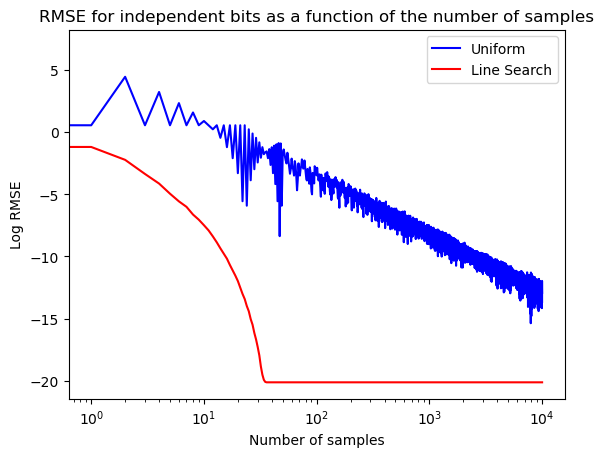

In [6]:
# Generate uniform data
n = 10000
d= 10



data = generate_dataset(n,d,1/np.sqrt(2))
max_iter = 10000



cg = experimentCGD(data, max_iter, "uniform",True)
mu_estimated =  cg.descent()
cg_ls = experimentCGD(data, max_iter, "line-search",True)
mu_estimated_ls =  cg_ls.descent()
   
log_rmse =cg.get_loss()
log_rmse_ls =cg_ls.get_loss()


plt.plot([i  for i in  range(len(log_rmse))], log_rmse, color="blue")
plt.plot([i  for i in range(len(log_rmse_ls))], log_rmse_ls, color="red")
plt.legend(["Uniform","Line Search"])
plt.xscale('log')

plt.title("RMSE for independent bits as a function of the number of samples")
plt.ylabel("Log RMSE")
plt.xlabel("Number of samples")
plt.show()


In [7]:
# Calculate the kullback leibler divergence for the original data distribution and the estimated one

def kl_divergence(p,q,tol=1e-20):
    """Calculate KL divergence for two distributions"""
    return p*np.log(p+tol/(q+tol))+(1-p)*np.log((1-p+tol)/((1-q)+tol))



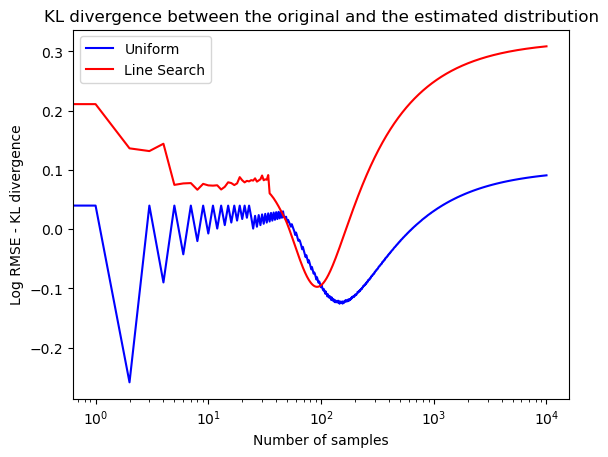

In [8]:
KL = []
KL_ls = []
p_data = np.array([0.5 for _ in range(d)])
for i in range(max_iter-1):
    sample = np.array(cg.get_samples()[:i+1])
    sample = np.sign(sample)
    p_sample = np.array([np.mean(sample[:,i]==1) for i in range(d)])
    kl = kl_divergence(p_sample,p_data)
    KL.append(np.log(np.linalg.norm(kl))/np.log(10))

    sample_ls = np.array(cg_ls.get_samples()[:i+1])
    sample_ls = np.sign(sample_ls)
    p_sample_ls = np.array([np.mean(sample_ls[:,i]==1) for i in range(d)])
    kl_ls = kl_divergence(p_sample_ls,p_data)
    KL_ls.append(np.log(np.linalg.norm(kl_ls))/np.log(10))

plt.xscale('log')
plt.ylabel('Log RMSE - KL divergence')
plt.xlabel('Number of samples')

plt.title('KL divergence between the original and the estimated distribution')
plt.plot(KL, color="blue",label='Uniform')
plt.plot(KL_ls, color="red",label='Line Search')
plt.legend(['Uniform','Line Search'])
plt.show()


#### Dependent Bits ####

100%|██████████| 10000/10000 [02:31<00:00, 66.15it/s]


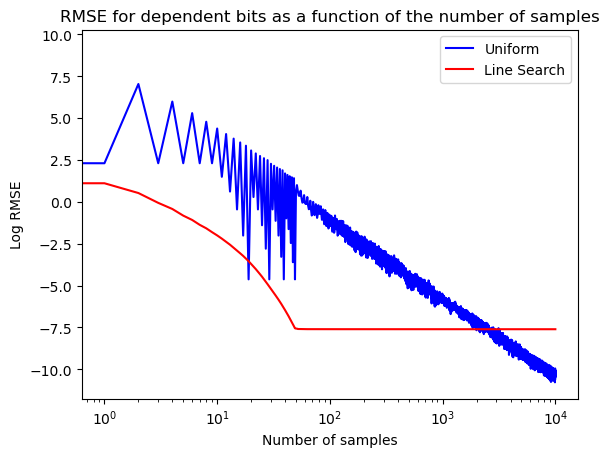

In [9]:
# Generate uniform data
n = 10000
d= 10



data = generate_dataset(n,d,0.5)
max_iter = 10000



cg = experimentCGD(data, max_iter, "uniform",False)
mu_estimated =  cg.descent()

cg_ls = experimentCGD(data, max_iter, "line-search",False)
mu_estimated_ls =  cg_ls.descent()

log_rmse =cg.get_loss()

log_rmse_ls =cg_ls.get_loss()


plt.plot([i  for i in  range(len(log_rmse))], log_rmse, color="blue")
plt.plot([i  for i in range(len(log_rmse_ls))], log_rmse_ls, color="red")
plt.legend(["Uniform","Line Search"])
plt.xscale('log')

plt.title("RMSE for dependent bits as a function of the number of samples")
plt.ylabel("Log RMSE")
plt.xlabel("Number of samples")
plt.show()


In [ ]:
KL = []
KL_ls = []
p_data = np.array([np.mean(data[:,i]==1) for i in range(d)]+[np.mean(data[:,i]==1)*np.mean(data[:,j]==1) for i in range(d) for j in range(d)])
for i in range(max_iter-1):
    sample = np.array(cg.get_samples()[:i+1])
    sample = np.sign(sample)
    p_sample = np.array([np.mean(sample[:,i]==1) for i in range(d)] + [np.mean(sample[:,i]==1)*np.mean(sample[:,j]==1) for i in range(d) for j in range(d)])
    kl = kl_divergence(p_sample,p_data)
    KL.append(np.log(np.linalg.norm(kl))/np.log(10))

    sample_ls = np.array(cg_ls.get_samples()[:i+1])
    sample_ls = np.sign(sample_ls)
    p_sample_ls = np.array([np.mean(sample_ls[:,i]==1) for i in range(d)]+[np.mean(sample_ls[:,i]==1)*np.mean(sample_ls[:,j]==1) for i in range(d) for j in range(d)])
    kl_ls = kl_divergence(p_sample_ls,p_data)
    KL_ls.append(np.log(np.linalg.norm(kl_ls))/np.log(10))

plt.xscale('log')
plt.ylabel('Log RMSE - KL divergence')
plt.xlabel('Number of samples')

plt.title('KL divergence between the original and the estimated distribution')
plt.plot(KL, color="blue",label='Uniform')
plt.plot(KL_ls, color="red",label='Line Search')
plt.legend(['Uniform','Line Search'])
plt.show()


### Estimation on graphical models ###

In this section, we try to reproduce the experiments on the section 5.2 with two distincts differences : d is setup to 10 (100 was impossible to run on our computers) and we only implemented line-search and uniform method.

As previously mentionned, we try to stick as much as possible to the variables in the article.

In this experiment, $\phi(x) = (x,xx^{T})$ and we need to create a covariance matrix and for simplification, we want that matrix to be with all variances equal to one (so that the correlation and covariance are the same and therefore computing the moment vector is easier).

In [10]:
def generate_gaussian(n,mean,cov):
    data = np.random.multivariate_normal(mean,cov,n)
    return data



In [13]:
# Generate a Covariance matrix with ones on the diagonal

np.random.seed(1)
n = 10000
d= 10
mean = np.zeros(d)
mat = np.random.uniform(-1/d,1/d,(d,d))
mat = mat@mat.T
cov = mat + 1.01*np.eye(d) - np.diag(np.diag(mat+0.01*np.eye(d)))



In [11]:
class experimentGM_CGD():
    def __init__(self, data, max_iter, method,covariance):
        self.data = data
        self.max_iter = max_iter
        self.method = method
        self.g=[]
        self.sample=[]
        self.loss = []
        self.rhos=[]
        self.weights =[]
        self.n = np.shape(data)[0]
        self.d = np.shape(data)[1]
        self.covariance = covariance
        self.mu = self.compute_moments_vector(data)
        

    def compute_moments_vector(self, data):
        """Compute the mu vector on the data"""
        mean = np.mean(self.data,axis = 0)
        cov = self.covariance.flatten()
        mu = np.zeros(self.d+self.d**2)
        mu[:self.d] = mean
        for i,element in enumerate(cov):
            mu[self.d+i] = 0.25 + (1/(2*np.pi))*np.arcsin(element)
        return mu


        
    def phi(self,x):
        """Compute the feature vector of x"""
        if x.shape == (self.d,):
            x = x.reshape((self.d,1))
            cov = x@(x.T)
            cov = cov.flatten()
            return np.concatenate([x.flatten(),cov])
        else:
            return x
    
    def get_gs(self):
        return self.g
    
    def get_samples(self):
        return self.sample
    
    def get_loss(self):
        return self.loss
    
    def get_rhos(self):
        return self.rhos
    
    def compute_log_rmse(self):
        """Compute the loss at the current iteration"""
        return np.log(np.linalg.norm(self.mu-self.g[-1])**2)
    
    def function_to_minimize(self,x):
        """Compute the fonction to be minimized in the optimisation step"""
        phi = self.phi(x)
        return phi.T @ (self.g[-1]-self.mu)

    def find_g_bar(self):
        """Compute the minimiser of the function to be minimized in the step of Frank-Wolfe Algorithm"""
        x_0 = self.phi(np.zeros(self.d)) 
        if len(self.g)>50:
            maxi = np.max(np.array(self.g),axis=0)
            mini = np.min(np.array(self.g),axis=0)
            bounds = [[m,M] for m,M in zip(mini,maxi)]

        else:
            bounds = [[-1,1]]*(self.d+self.d**2)
        res = minimize(self.function_to_minimize,x_0,bounds=bounds)
    
        return res.x
    
    def descent(self):
        """Performs the descent for a number of iteration and returns the moment vector found"""
        if self.method == 'uniform':
            g_0 = np.random.uniform(-1,1,self.d)
            self.g.append(self.phi(g_0))
            self.weights.append(np.zeros(self.d))
            for i in tqdm(range(self.max_iter)):
                g_bar = self.find_g_bar()
                self.sample.append(g_bar)
                g_bar_phi = self.phi(g_bar)
                self.g.append((1-1/(i+1))*self.g[-1]+(1/(i+1))*g_bar_phi)
                
                self.weights.append(i*((self.mu-self.g[-1])))
                
                self.loss.append(self.compute_log_rmse())
            return self.g[-1]
        
        elif self.method =='line-search':
            g_0 = np.random.uniform(-1,1,self.d)
            self.g.append(self.phi(g_0))
            self.weights.append(np.zeros(self.d))
            

            for i in tqdm(range(self.max_iter)):
                g_bar = self.find_g_bar()
                self.sample.append(g_bar)
                g_bar_phi = self.phi(g_bar)
                rho = (self.g[-1]-self.mu).T@(self.g[-1]-g_bar_phi)/(np.linalg.norm(self.g[-1]-g_bar_phi)**2+1e-6)

                self.g.append((1-rho)*self.g[-1]+rho*g_bar_phi)
                self.rhos.append(rho)

                self.loss.append(self.compute_log_rmse())
            return self.g[-1]
                


100%|██████████| 10000/10000 [02:31<00:00, 66.06it/s]


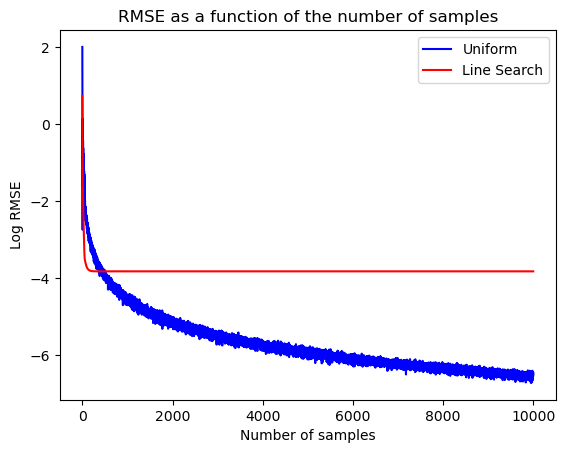

In [14]:

data = generate_gaussian(n,mean,cov)
data.shape
data = np.sign(data)

max_iter = 10000



cg = experimentGM_CGD(data, max_iter, "uniform",cov)
mu_estimated =  cg.descent()

cg_ls = experimentGM_CGD(data, max_iter, "line-search",cov)
mu_estimated_ls =  cg_ls.descent()


log_rmse =cg.get_loss()

log_rmse_ls =cg_ls.get_loss()

plt.plot([i for i in  range(len(log_rmse))], log_rmse/np.log(10), color="blue")

plt.plot([i for i in range(len(log_rmse_ls))], log_rmse_ls/np.log(10), color="red")

plt.legend(["Uniform","Line Search"])
plt.title("RMSE as a function of the number of samples")
plt.xlabel("Number of samples")
plt.ylabel("Log RMSE")

plt.show()